In [1]:
"""
CheXNet applied to chest X-ray images classifying pneumonia vs normal.

Reimplementation of the paper: 
https://doi.org/10.48550/arXiv.1711.05225

The dataset can be downloaded from here:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
"""

import tensorflow as tf
from loss import WeightedCrossEntropyBinaryLoss
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
import prepare_data
import os

In [2]:
# Local path to the input
input_path = 'C:/Users/marta/OneDrive/Desktop/Osnabruck/ImplementingANNswithTensorFlow/FinalProject/chest_xray/'

# Checkpoint file path
checkpoint_filepath = './Checkpoint/weights.hdf5' 

# Train data path
train_data_path = input_path+'train'

# Validation data path
val_data_path = input_path+'val'

# Testing data path
test_data_path=input_path+'test'

# Hyperparameters set in accordance with the methods of the original paper
img_dims = 224
n_epochs = 10
batch_size = 16 
output_size = 1

# Getting the data
train_gen, val_gen, test_gen, test_data, test_labels = prepare_data.prepare_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
class CheXNet(tf.keras.Model):
  """
  The CheXNet model that uses DenseNet121 as its backbone.
  """

  def __init__ (self):
    """
    The constructor instantiates the weights and the model.
    """
    super().__init__()

    # Instantiate weights and steps and set them to None
    self.zero_weight = None
    self.one_weight = None
    self.train_steps = None
    self.val_steps = None

    # get_model() will initialize this to DenseNet121 model
    self.model = None
  
  def get_weights(self, train_data_path):
    """
    Computes class distribution of pneumonia vs normal images.

    Args:
      train_data_path: path to training data.
      val_data_path: path to validation data.
    """

    # Count images in each class in the train data
    n_normal = len(os.listdir(train_data_path + '/NORMAL'))
    n_pneumonia = len(os.listdir(train_data_path + '/PNEUMONIA'))

    # Compute class distribution
    self.one_weight = float(n_normal)/(n_normal+n_pneumonia)
    self.zero_weight = float(n_pneumonia)/(n_normal+n_pneumonia)


  def get_model(self):
    
    # DenseNet121 expects number of channels to be 3
    input = Input(shape=(img_dims, img_dims, 3), batch_size=batch_size)

    # using pretrained DenseNet121 as the foundation of the model
    base_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',
                                                            input_shape=(img_dims, img_dims, 3), pooling='avg')
    
    # Add custom output layers
    x = base_model.output
    x = tf.keras.layers.Dense(output_size, activation='sigmoid')(x)

    self.model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

    # Use weighted binary crossentropy loss
    loss = WeightedCrossEntropyBinaryLoss(self.zero_weight, self.one_weight)

    # Compile the model
    self.model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999),
                       loss=loss.weighted_binary_crossentropy, metrics=['accuracy'])
    
    return self.model

# Instantiate the CheXNet model
chexnet = CheXNet()

# Compute class distribution of pneumonia vs normal images
chexnet.get_weights(train_data_path)

# Create and compile the DenseNet121 model
model = chexnet.get_model()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    mode='min',
    save_best_only=True)

In [7]:
# Fitting the model
history = model.fit(train_gen,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    steps_per_epoch=train_gen.samples // batch_size,
                    validation_steps=val_gen.samples // batch_size,
                    validation_data=test_gen,
                    callbacks=[reduce_lr, model_checkpoint])


Epoch 1/10
326/326 [==============================] - 882s 3s/step - loss: 0.0995 - accuracy: 0.9007 - val_loss: 0.3579 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - 874s 3s/step - loss: 0.0739 - accuracy: 0.9233 - val_loss: 0.1376 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9390
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
326/326 [==============================] - 869s 3s/step - loss: 0.0621 - accuracy: 0.9390 - val_loss: 1.4448 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 869s 3s/step - loss: 0.0432 - accuracy: 0.9517 - val_loss: 0.0646 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/10
326/326 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9651
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
326/326 [============================

In [12]:

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Load the model with the lowest validation loss
model.load_weights(checkpoint_filepath)

loss, accuracy = model.evaluate(test_data, test_labels, batch_size)

# # Compute predictions and round to obtain binary predictions
# yhat = np.round(model.predict(test_data, batch_size=16))

# # Compute accuracy, confusion matrix, and metrics from confusion matrix
# acc = accuracy_score(test_labels, yhat) * 100
# tn, fp, fn, tp = confusion_matrix(test_labels, yhat).ravel()
# precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, yhat, average='binary')

# # Print the results 
# print(f"Confusion Matrix:\n{confusion_matrix(test_labels, yhat)}\n")
# print(f"Accuracy: {acc}%")
# print(f"Precision: {precision * 100}%")
# print(f"Recall: {recall * 100}%")
# print(f"F1 Score: {f1_score * 100}")
# print(f"Train accuracy: {(history.history['accuracy'][-1])*100}%")


39/39 [==============================] - 20s 518ms/step
Confusion Matrix:
[[216  18]
 [ 18 372]]

Accuracy: 94.23076923076923%
Precision: 95.38461538461539%
Recall: 95.38461538461539%
F1 Score: 95.38461538461539
Train accuracy: 96.60659432411194%


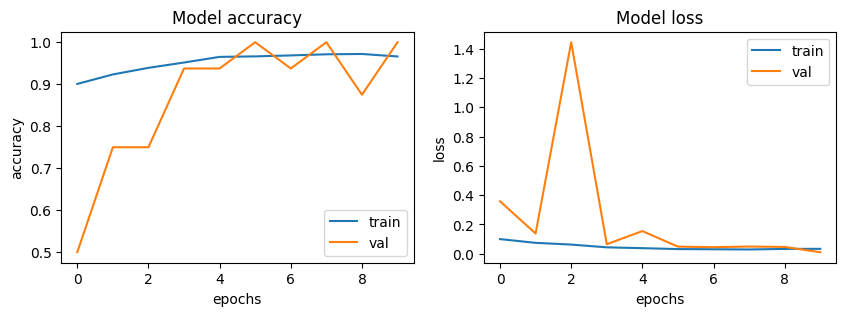

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])